# (11468) Shantanunaidu orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

In [3]:
body_id = '11468'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = nongrav_info['radius']
de_kernel = 441

In [4]:
add_gaia_obs = False
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 1733 observations from the MPC.
	Filtered to 1733 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: GSC
	Unknown star catalog: UNK
	No debiasing needed for 719 observations.
	Debiased 984 observations.
	No bias information for 30 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 1548 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 484 observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.452			 0.511			 903.491			 0.261
2			 0.452			 0.509			 897.382			 0.259
3			 0.452			 0.509			 897.382			 0.259
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.414			 0.483			 809.781			 0.235
5			 0.414			 0.483			 809.759			 0.235
Converged after rejecting outliers. Rejected 5 out of 1733 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 5 (of 5):
RMS unweighted: 0.41375604584436365
RMS weighted: 0.4833521441842396
chi-squared: 809.759137466482
reduced chi-squared: 0.2347127934685455
square root of reduced chi-squared: 0.48447166425761734
--------------------------------------------------------------
Solution Time: MJD 57630.000 TDB = 2016-08-30 00:00:00.000 TDB
Solution Observation Arc: 15746.60 days (43.11 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			1.66668735292e-01		2.26411771512e-09		1.66668698515e-01		3.10404728834e-08		-3.67773176913e-08		-16.244
q			2.56499149688e+00		2.93037414574e-09		2.56499160226e+00		9.71550152850e-08		+1.05374469594e-07		+35.959
tp			5.75112709974e+04		4.23197432606e-06		5.75112710102e+04		4.66114823008e-05		+1.28371320898e-05		+3.033
om			2.06374342935e+02		6.73526438176e-06		2.06374243392e+02		2.17638040849e

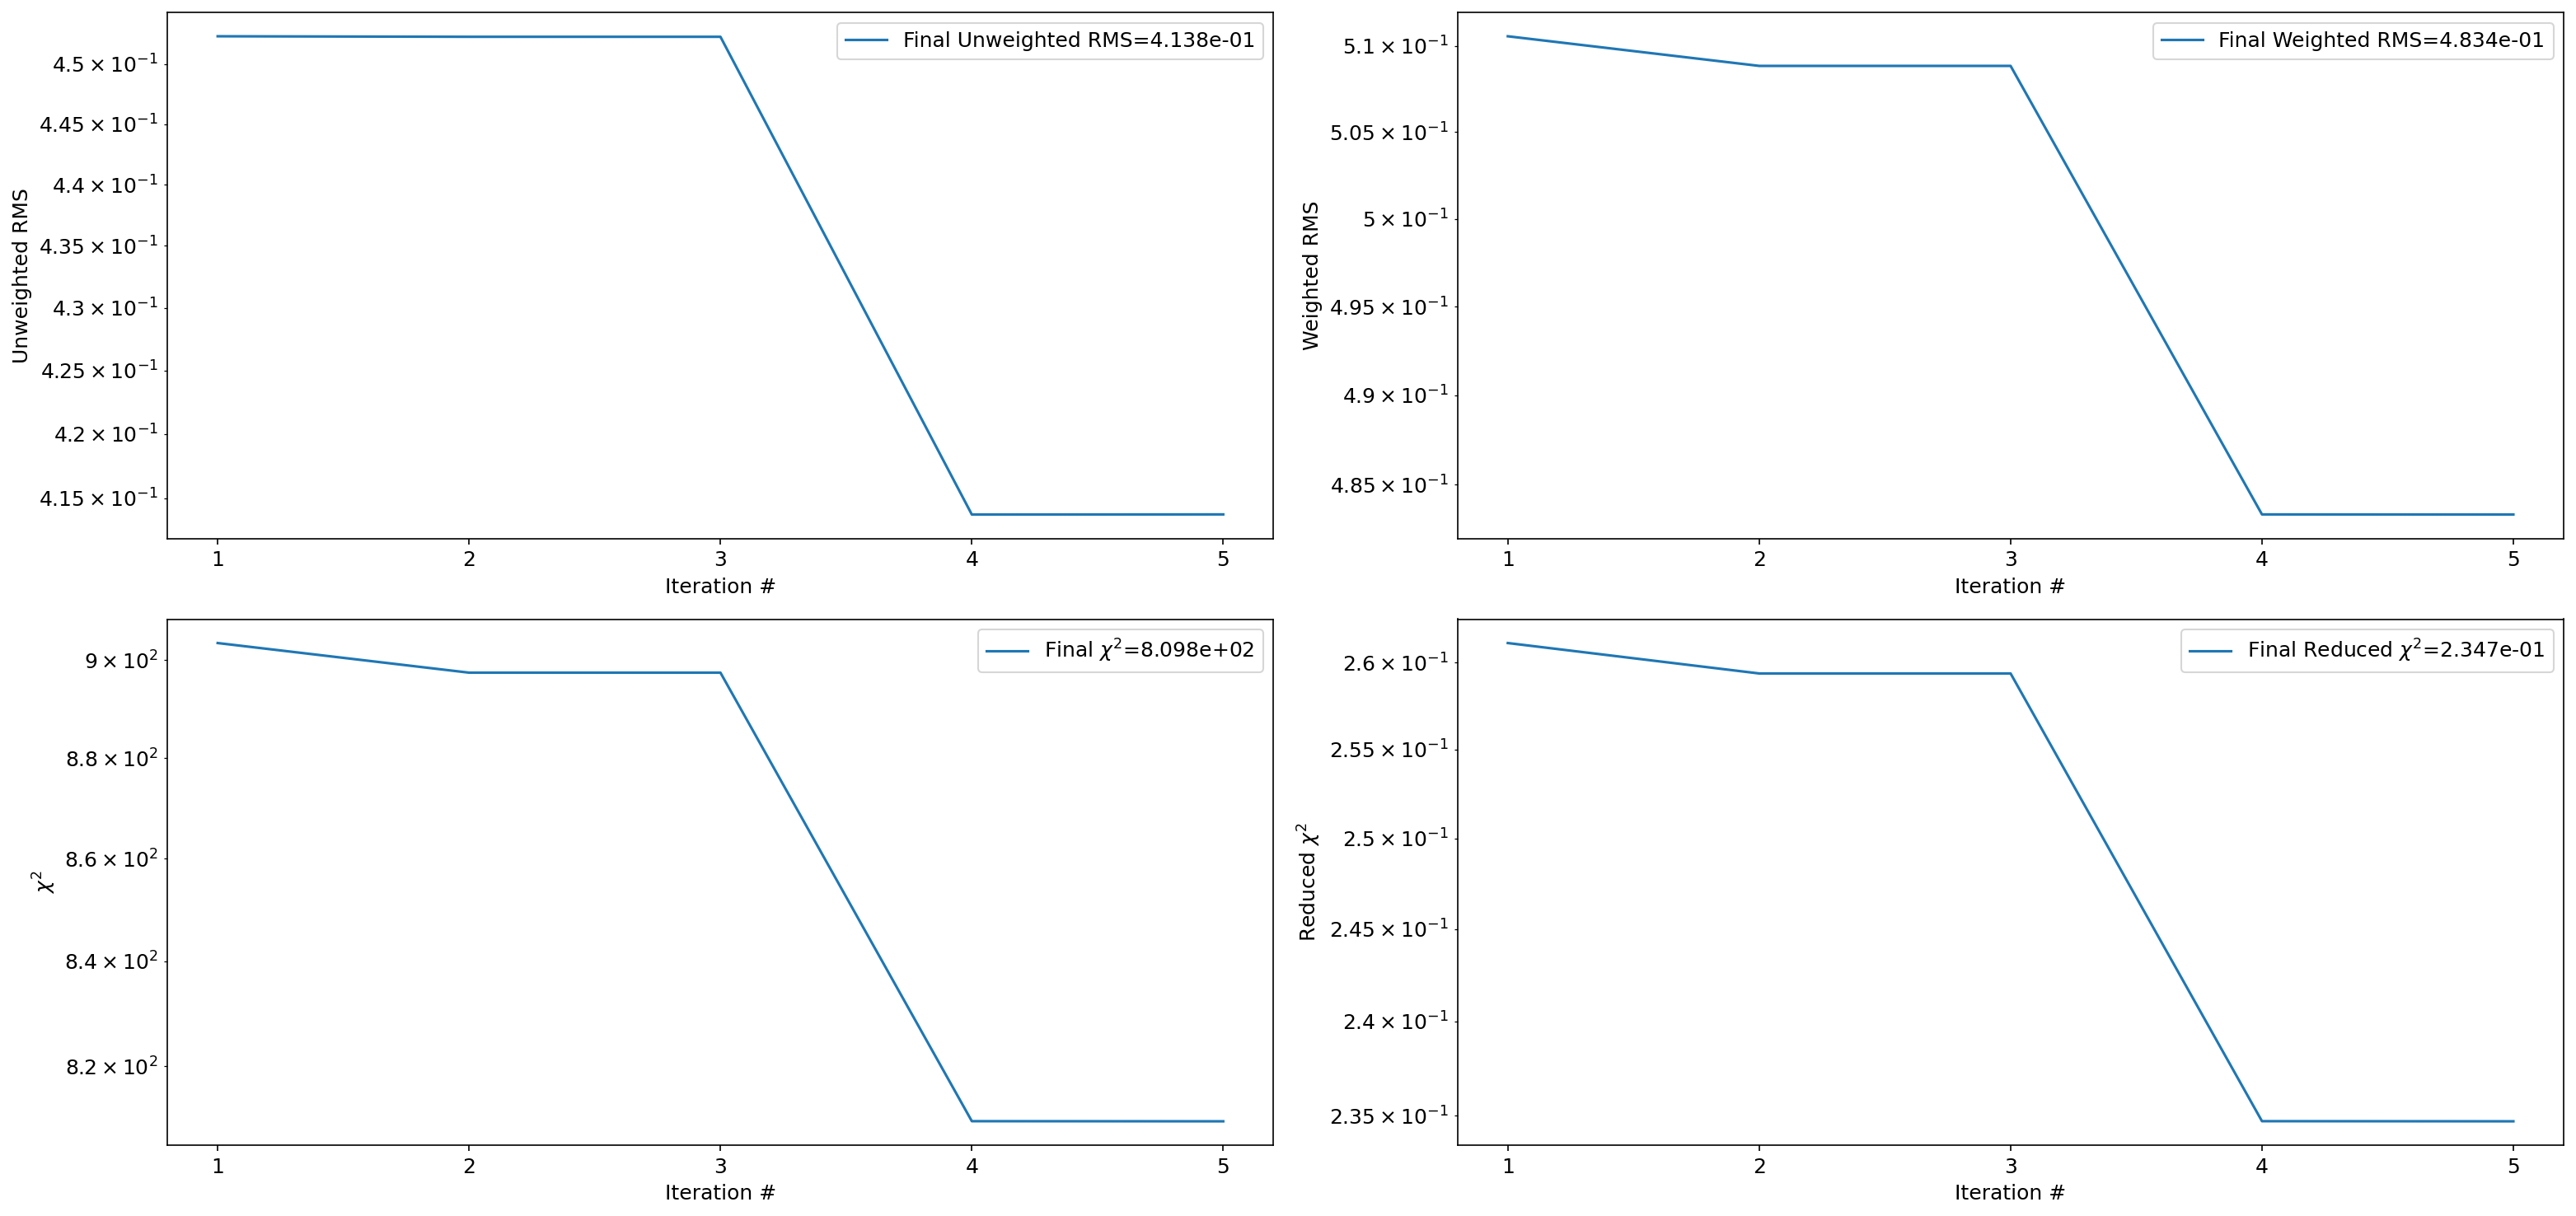

In [8]:
fit_sim.plot_summary(auto_close=True)

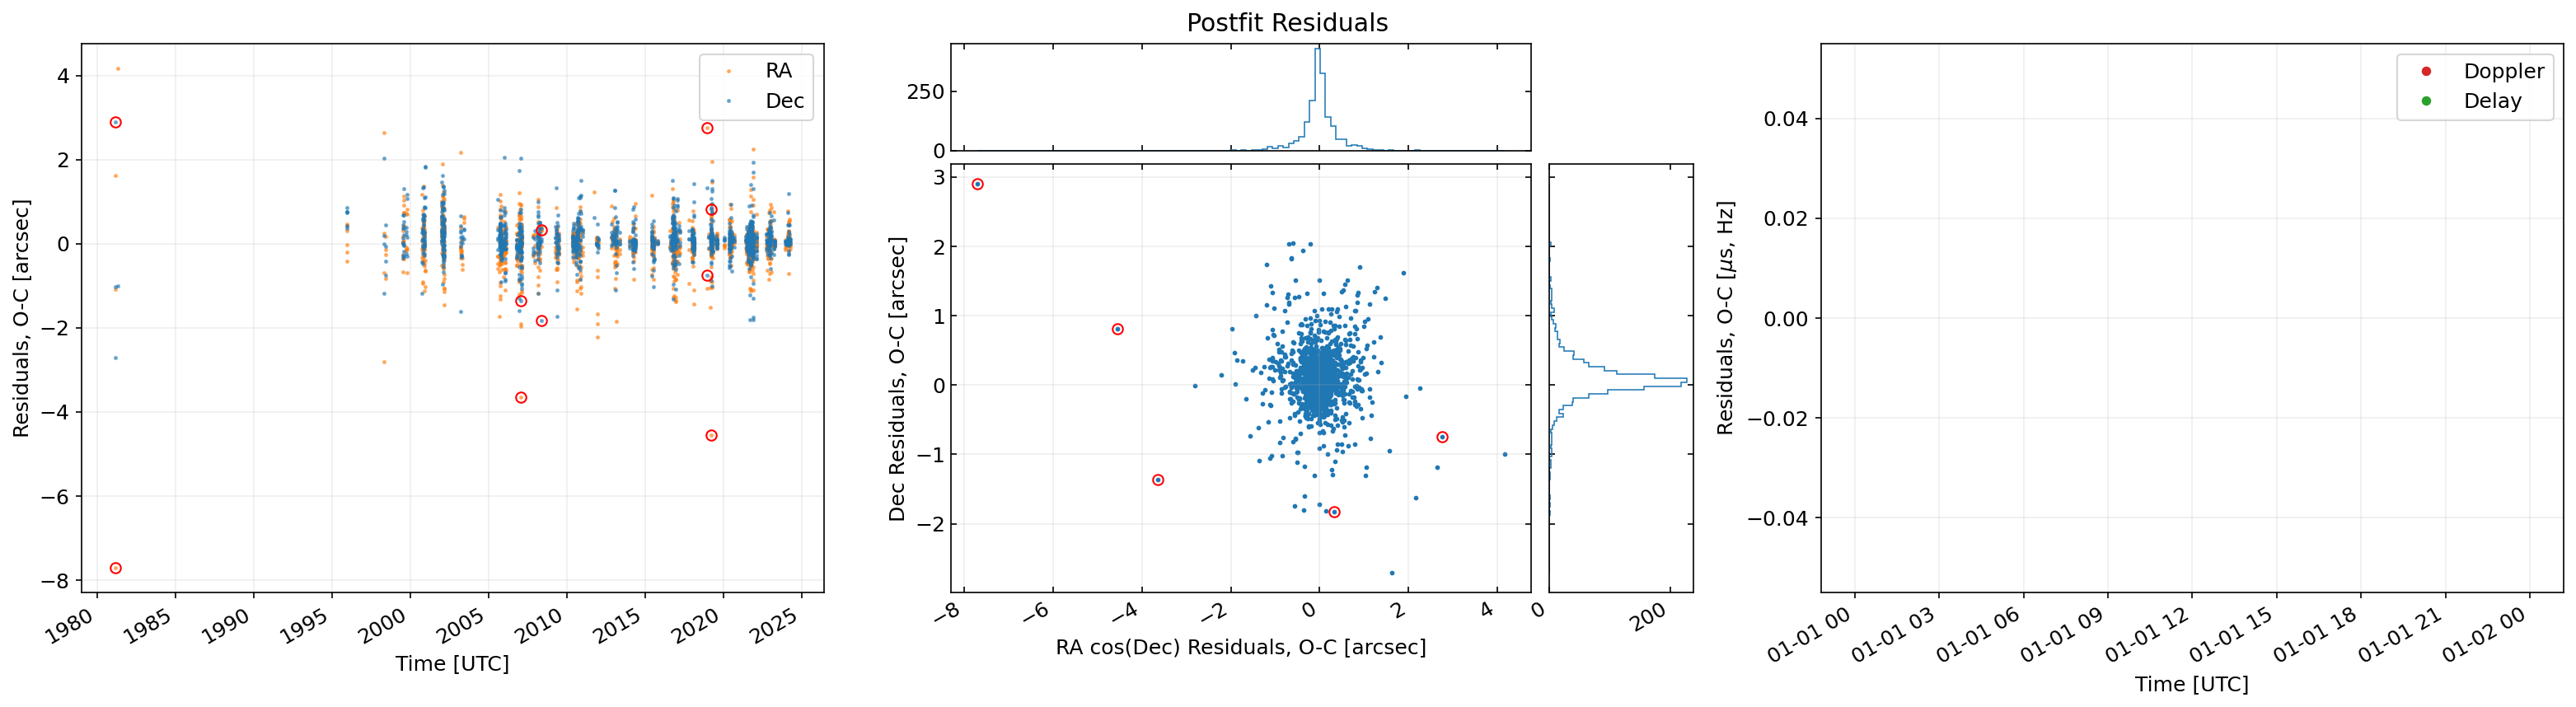

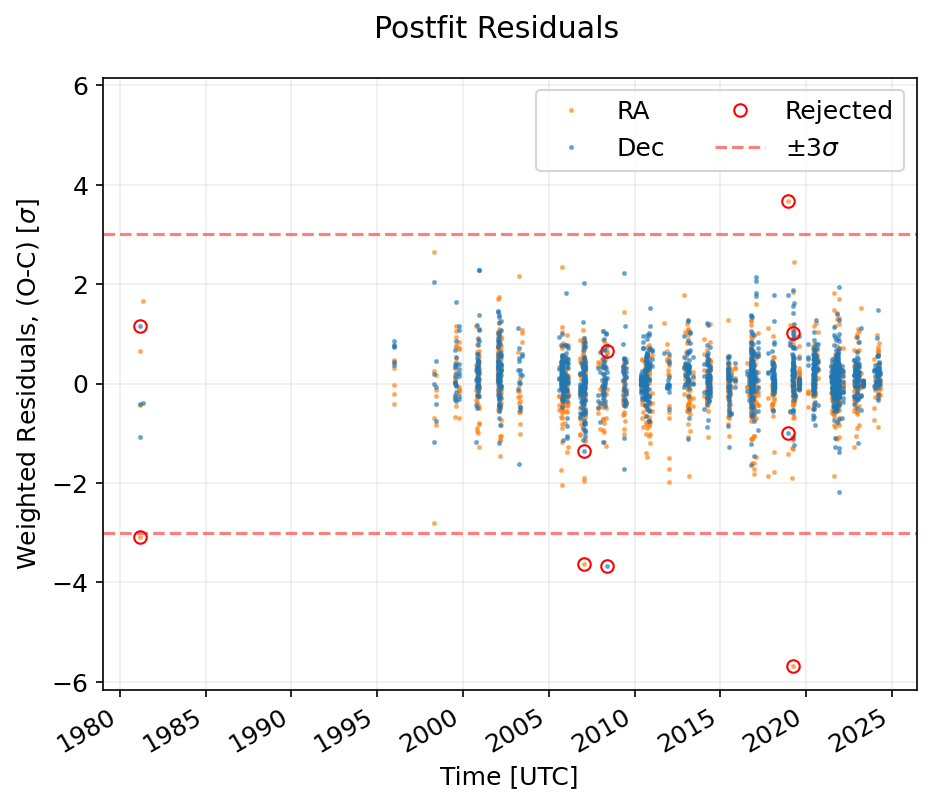

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 87.85
Mahalonobis distance between GRSS and JPL solution: 2.38
Bhattacharya distance between JPL and GRSS solution: 6.8480
Bhattacharya coefficient between JPL and GRSS solution: 0.0011


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90

AssertionError: 